In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

# Analyzing the flexible path length simulation

In [2]:
filename = "alanine_dipeptide_tps.nc"

In [3]:
flexible = paths.AnalysisStorage(filename)
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [4]:
print "File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots)
)

File size: 17.25GB for 10001 steps, 922214 snapshots


In [5]:
flex_scheme.move_summary(flexible)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 5649/10000 (56.49%)


In [6]:
history = ops_vis.ReplicaHistoryTree(
    storage=flexible,
    steps=flexible.steps[0:50],
    replica=0
)

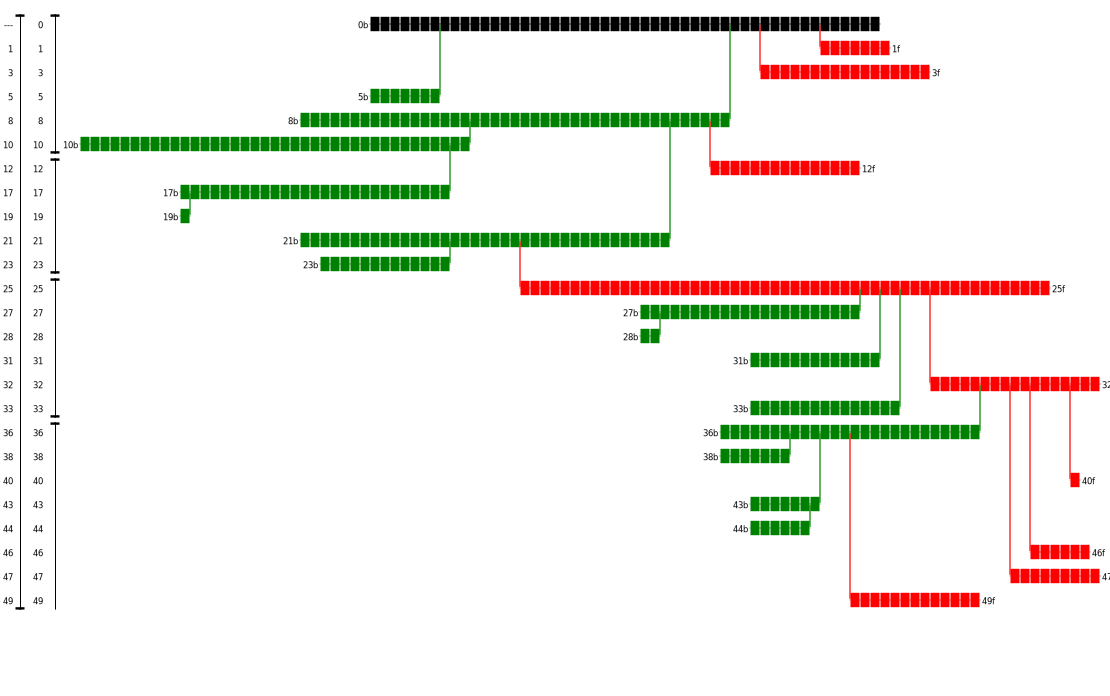

In [7]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [8]:
full_history = ops_vis.ReplicaHistoryTree(
    storage=flexible,
    steps=flexible.steps[0:len(flexible.steps)],
    replica=0
)
print "Decorrelated trajectories:", len(full_history.decorrelated_trajectories)

Decorrelated trajectories: 915


Maximum: 392 (7.84 ps)
Average: 78.22 (1.564 ps)


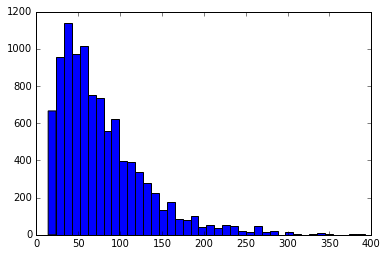

In [9]:
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40);
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+(np.mean(path_lengths)*engine.snapshot_timestep).format("%.3f")+")"

In [10]:
# TODO: path density plots (arbitrary dimension!)

In [11]:
#import nglview as nv
#nv.show_mdtraj(traj.md())

In [15]:
# TODO: "transition state analysis"
# my thought: 
# * pick 100 (decorrelated) trajectories
# * take every 3rd frame (or something like that)
# * run 50 (or 100?) committor shots with randomized initial velocities
# * say something about which points are likely at/near the 50% isocommittor

# Analyzing the fixed path length simulation

In [16]:
fixed = paths.AnalysisStorage("alanine_dipeptide_fixed_tps.nc")

In [17]:
engine = fixed.engines[0]
fixed_scheme = fixed.schemes[0]

print "File size: {0} for {1} steps, {2} snapshots".format(
    fixed.file_size_str,
    len(fixed.steps),
    len(fixed.snapshots)
)

File size: 7.50GB for 1001 steps, 401394 snapshots


In [18]:
fixed_scheme.move_summary(fixed)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 477/1000 (47.70%)


In [19]:
history = ops_vis.ReplicaHistoryTree(
    storage=fixed,
    steps=fixed.steps[0:50],
    replica=0
)

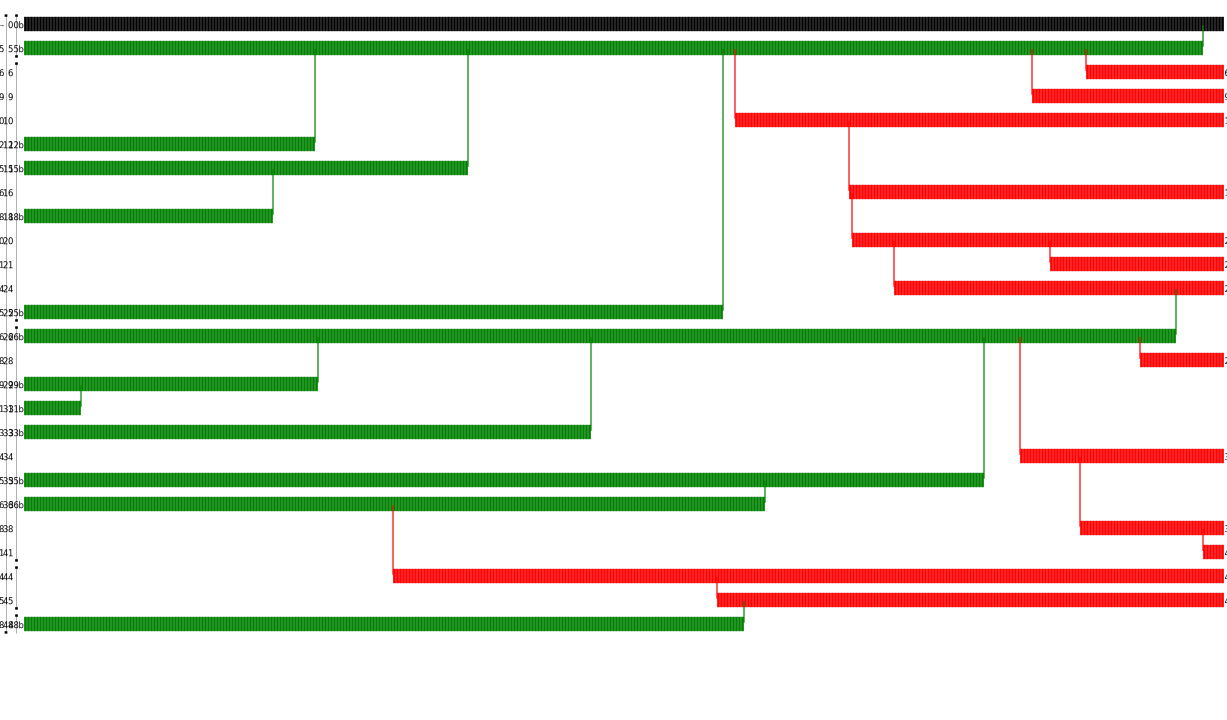

In [20]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 3
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [21]:
full_history = ops_vis.ReplicaHistoryTree(
    storage=fixed,
    steps=fixed.steps[0:len(fixed.steps)],
    replica=0
)
print "Decorrelated trajectories:", len(full_history.decorrelated_trajectories)

Decorrelated trajectories: 37


In [29]:
# checking for recrossings
alpha = fixed.volumes.find('alpha')
beta = fixed.volumes.find('beta')
recrossing_ensemble = paths.SequentialEnsemble([
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(beta),
    paths.OptionalEnsemble(paths.AllOutXEnsemble(alpha | beta)),
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(alpha) 
])

In [39]:
trials_with_recrossing = []
for step in fixed.steps:
    recrossings = [] # default for no trials in step.change
    for test in step.change.trials:
        recrossings = recrossing_ensemble.split(test.trajectory)
    if len(recrossings) > 0:
        trials_with_recrossing += [step]

In [40]:
accepted_recrossings = [step for step in trials_with_recrossing if step.change.accepted is True]

In [41]:
print "Trials with recrossings:", len(trials_with_recrossing)
print "Accepted moves with recrossings:", len(accepted_recrossings)

Trials with recrossings: 40
Accepted moves with recrossings 6


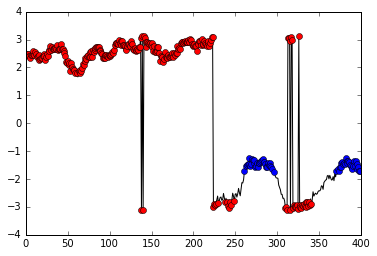

In [49]:
psi = fixed.cvs.find('psi')
trajectory = accepted_recrossings[0].active[0].trajectory
in_alpha_indices = [trajectory.index(s) for s in trajectory if alpha(s)]
in_alpha_psi = [psi(trajectory)[i] for i in in_alpha_indices]
in_beta_indices = [trajectory.index(s) for s in trajectory if beta(s)]
in_beta_psi = [psi(trajectory)[i] for i in in_beta_indices]

plt.plot(psi(trajectory), 'k-')
plt.plot(in_alpha_indices, in_alpha_psi, 'ro')
plt.plot(in_beta_indices, in_beta_psi, 'bo')


In [45]:
recrossings_per = []
for step in accepted_recrossings:
    for test in step.change.trials:
        recrossings_per.append(len(recrossing_ensemble.split(test.trajectory)))

In [46]:
print recrossings_per

[1, 1, 1, 1, 1, 1]


# Comparing the fixed and flexible simulations

In [58]:
# transition path length distribution
flex_ens = flex_scheme.network.sampling_ensembles[0]
fixed_transition_segments = sum([flex_ens.split(step.active[0].trajectory) for step in fixed.steps],[])
fixed_transition_length = [len(traj) for traj in fixed_transition_segments]

In [61]:
print len(fixed_transition_length)

1021


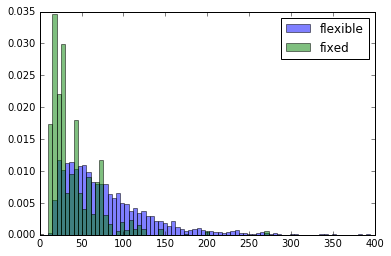

In [67]:
bins = np.linspace(0, 400, 80);
plt.hist(path_lengths, bins, alpha=0.5, normed=True, label="flexible");
plt.hist(fixed_transition_length, bins, alpha=0.5, normed=True, label="fixed");
plt.legend(loc='upper right');

In [69]:
# I bet that the reason for this is that fixed is sampling BOTH directions of transitions, while flexible isn't
# In other words, the event isn't really rare enough! Try again with a cutoff at 250 frames?